## Projection Method Code
Given a non-physical magnetic field with some non-zero divergence, it can be projected to a divergence free field.
That is, $\mathbf{B}_* = \nabla\times \mathbf{A} + \nabla\phi$, with $\phi$ nonzero. Then, computing $\phi$ from
$$ \nabla^2\phi = \nabla\cdot B_* $$
Using the centered finite difference applied to the Laplacian as the divergence of the gradient of $\phi$, the following condition is found for
$$ \begin{align*} \frac{(x_{i+2}-x_i)}{(x_{i+2}-x_i)(x_{i+1}-x_{i-1})(x_i-x_{i-2})}\phi_{i-2,j}+\frac{(x_i-x_{i-2})}{(x_{i+2}-x_i)(x_{i+1}-x_{i-1})(x_i-x_{i-2})}\phi_{i+2,j}&\quad+\\
\frac{(y_{j+2}-y_j)}{(y_{j+2}-y_j)(y_{j+1}-y_{j-1})(y_j-y_{j-2})}\phi_{i,j-2}+\frac{(y_j-y_{j-2})}{(y_{j+2}-y_j)(y_{j+1}-y_{j-1})(y_j-y_{j-2})}\phi_{i,j+2}&\quad-\\
\left( \frac{(x_{i+2}-x_{i-2})}{(x_{i+2}-x_i)(x_{i+1}-x_{i-1})(x_i-x_{i-2})} + \frac{(y_{j+2}-y_{j-2})}{(y_{j+2}-y_j)(y_{j+1}-y_{j-1})(y_j-y_{j-2})} \right)\phi_{i,j}&\quad=\quad \frac{B_{0,i+1,j}-B_{0,i-1,j}}{x_{i+1}-x_{i-1}}+\frac{B_{1,i,j+1}-B_{1,i,j-1}}{y_{j+1}-y_{j-1}} \end{align*}$$
Where the $B$ above come from $\mathbf{B}_*$. Then, update the magnetic field with $\mathbf{B} = \mathbf{B_*} - \nabla\phi$.

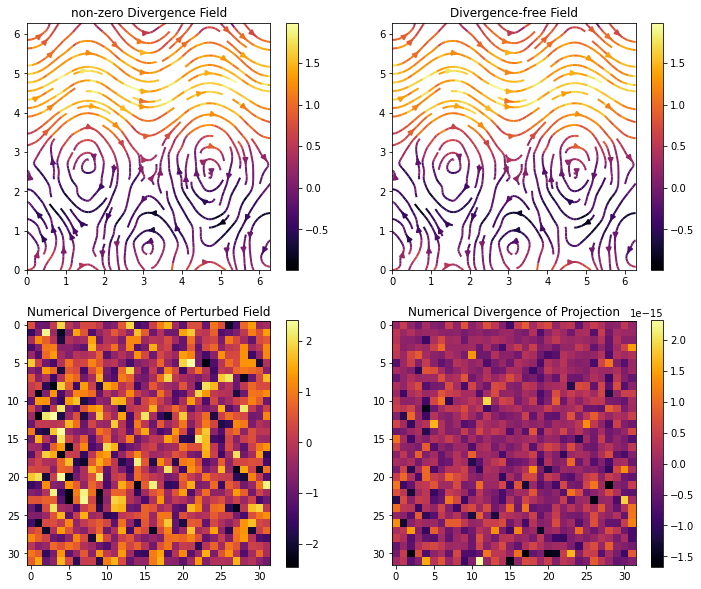

In [8]:
### Imports
import numpy as np
import matplotlib.pyplot as plt

# Discretization on the 2pi square, with N+1 points along each axis
l = 2*np.pi
h = 0.2 # approximate grid spacing
N = int(l/h)
x = np.linspace(0,l,N+1) # N+1 points spanning 0,l
xx, yy = np.meshgrid(x,x)

### Initial Magnetic Field, perturbed IC for Orszag-Tang Vortex Problem
Bstar0 = -np.sin(yy)
Bstar0 += np.random.rand(N+1,N+1)
Bstar1 = np.sin(2*xx)
# Streamline plot of pre-divergence cleaning method
fig = plt.figure(figsize=(12,10))
ax0 = fig.add_subplot(221)
strm = ax0.streamplot(xx, yy, Bstar0, Bstar1, color=Bstar0, linewidth=2, cmap='inferno')
fig.colorbar(strm.lines)
ax0.title.set_text('non-zero Divergence Field')

### Matrix Operators from condition on phi above
DDx, DDy = xx*0, xx*0 #setting sizes
Dx, Dy = xx*0, xx*0
x = np.linspace(-2*h,l+2*h,N+5) # increase x and y domains for correct periodic boundaries
y = np.linspace(-2*h,l+2*h,N+5)
for i in range(N+1):
    xi = i+2
    yj = i+2
    DDx[i][i] = -(x[xi+2]-x[xi-2])/((x[xi+2]-x[xi])*(x[xi+1]-x[xi-1])*(x[xi]-x[xi-2]))
    DDx[i][i-2] = 1/((x[xi+1]-x[xi-1])*(x[xi]-x[xi-2]))
    DDx[i][(i+2)%(N+1)] = 1/((x[xi+2]-x[xi])*(x[xi+1]-x[xi-1]))
    
    DDy[i][i] = -(y[yj+2]-y[yj-2])/((y[yj+2]-y[yj])*(y[yj+1]-y[yj-1])*(y[yj]-y[yj-2]))
    DDy[i][i-2] = 1/((y[yj+1]-y[yj-1])*(y[yj]-y[yj-2]))
    DDy[i][(i+2)%(N+1)] = 1/((y[yj+2]-y[yj])*(y[yj+1]-y[yj-1]))
    
    Dx[i][(i+1)%(N+1)] = 1/(x[xi+1]-x[xi-1])
    Dx[i][i-1] = -1/(x[xi+1]-x[xi-1])
    
    Dy[i][(i+1)%(N+1)] = 1/(y[yj+1]-y[yj-1])
    Dy[i][i-1] = -1/(y[yj+1]-y[yj-1])
    
I = np.identity(N+1)
L = np.kron(I,DDx)+np.kron(DDy,I) # operator for flattened system
# Compute numerical divergence of starting condition and plot it
DxBstar0 = np.matmul(np.kron(I,Dx),np.matrix.flatten(Bstar0))
DyBstar1 = np.matmul(np.kron(Dy,I),np.matrix.flatten(Bstar1))
divBstar = (DxBstar0+DyBstar1).reshape(N+1,N+1)
ax2 = fig.add_subplot(223)
hmap = ax2.imshow(divBstar, cmap='inferno')
fig.colorbar(hmap)
ax2.title.set_text('Numerical Divergence of Perturbed Field')

### Compute phi at each point from linear system of (N+1)^2 equations
phi = np.linalg.solve(L,DxBstar0+DyBstar1)

### Update to divergence free field and streamline plot
Dxphi = np.matmul(np.kron(I,Dx),phi)
Dyphi = np.matmul(np.kron(Dy,I),phi)
B0 = Bstar0 - Dxphi.reshape(N+1,N+1)
B1 = Bstar1 - Dyphi.reshape(N+1,N+1)
ax1 = fig.add_subplot(222)
strmstar = ax1.streamplot(xx, yy, Bstar0, Bstar1, color=Bstar0, linewidth=2, cmap='inferno')
fig.colorbar(strmstar.lines)
ax1.title.set_text('Divergence-free Field')

# Check zero divergence condition and plot:
DxB0 = np.matmul(np.kron(I,Dx),np.matrix.flatten(B0))
DyB1 = np.matmul(np.kron(Dy,I),np.matrix.flatten(B1))
divB = (DxB0+DyB1).reshape(N+1,N+1)
ax3 = fig.add_subplot(224)
hmap = ax3.imshow(divB, cmap='inferno')
fig.colorbar(hmap)
ax3.title.set_text('Numerical Divergence of Projection')
plt.show()

Note the field after the projection has maximum numerical divergence on the order $10^{-15}$. Computing the numerical divergence of an analytically divergence free field, gives a maximum on the order $10^{-16}$.